Hypothesis: The strength of the Georges Bank anomalously cold SST follows a pattern by season
* this can be tested with OISST (NeapTides_Analysis) or by buoys

**OISST Analysis**

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
from datetime import datetime
import pandas as pd
import glob

In [2]:
sst_path = "OISST_data/"

In [3]:
ds_name = "OISST_data/oisst-avhrr-v02r01.20230902.nc"
ds = xr.open_dataset(ds_name)
date = ds_name[30:38]

In [4]:
#--- Filter to the Georges Bank region
min_lon = -71.5
min_lat = 37
max_lon = -64
max_lat = 47

ds = ds.sel(lat=slice(min_lat,max_lat), lon=slice(min_lon+360,max_lon+360))

Defining the region of interest (Georges Bank, ROI) and the region of comparison (ROC)

In [5]:
roi_lon1 = -70.25  # Western longitude of the ROI
roi_lon2 = -68.75  # Eastern longitude of the ROI
roi_lat1 = 40.75   # Southern latitude of the ROI
roi_lat2 = 41.5    # Northern latitude of the ROI

roc_lon1 = -70.25  # Western longitude of the ROI
roc_lon2 = -68.75  # Eastern longitude of the ROI
roc_lat1 = 41.5   # Southern latitude of the ROI
roc_lat2 = 43.5    # Northern latitude of the ROI

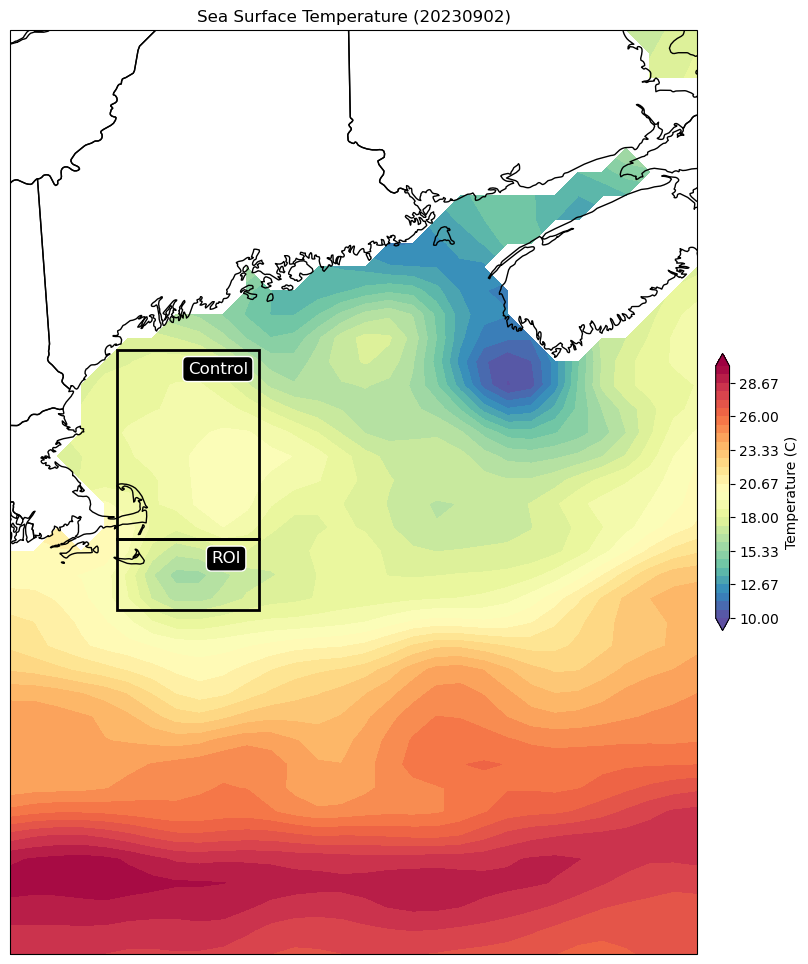

In [6]:
roi_box = mpatches.Rectangle(
    xy=(roi_lon1, roi_lat1),
    width=roi_lon2 - roi_lon1,
    height=roi_lat2 - roi_lat1,
    fill=False,
    edgecolor='black',
    linewidth=2.0,
    transform=ccrs.PlateCarree()
)

roc_box = mpatches.Rectangle(
    xy=(roc_lon1, roc_lat1),
    width=roc_lon2 - roc_lon1,
    height=roc_lat2 - roc_lat1,
    fill=False,
    edgecolor='black',
    linewidth=2.0,
    transform=ccrs.PlateCarree()
)

projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(10, 30, 31)

c=ax.contourf(ds.lon, ds.lat, ds.sst[0][0], cmap=cmap, extend='both', levels=levels)
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Sea Surface Temperature ('+date+')')
clb.set_label('Temperature (C)')
ax.add_patch(roi_box)
ax.add_patch(roc_box)

label_text_roi = "ROI"
ax.annotate(label_text_roi, xy=(roi_lon1, roi_lat1), xytext=(roi_lon2 - 0.5, roi_lat2 - 0.25), color='white',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="black"))
label_text_roc = "Control"
ax.annotate(label_text_roc, xy=(roc_lon1, roc_lat1), xytext=(roc_lon2 - 0.75, roc_lat2 - 0.25), color='white',
            fontsize=12, bbox=dict(boxstyle="round,pad=0.3", edgecolor="white", facecolor="black"))

ax.add_feature(cfeature.STATES)

Finding the average SST for each region

In [7]:
sst_result_df = pd.DataFrame(columns=['Datetime', 'ROI_SST', 'Control_SST'])

nc_files = sorted(glob.glob(sst_path+'*.nc'))
for file_path in nc_files:
    #print(file_path[30:38])
    dataset = xr.open_dataset(file_path)
    
    #--- Cropped to the region of interest
    roi_ds = dataset.sel(lat=slice(roi_lat1,roi_lat2), lon=slice(roi_lon1+360,roi_lon2+360))
    num_pixels = len(roi_ds.lat)*len(roi_ds.lon)
    roi_total_sst = (roi_ds.sst.sum().values)/num_pixels
    
    #--- Cropped to the control region
    roc_ds = dataset.sel(lat=slice(roc_lat1,roc_lat2), lon=slice(roc_lon1+360,roc_lon2+360))
    num_pixels = len(roc_ds.lat)*len(roc_ds.lon)
    roc_total_sst = (roc_ds.sst.sum().values)/num_pixels
    
    dt = datetime.strptime(file_path[30:38], "%Y%m%d")
    
    sst_result_df = sst_result_df.append({'Datetime': dt, 'ROI_SST': roi_total_sst, 'Control_SST': roc_total_sst}, ignore_index=True)

In [8]:
sst_result_df['Anomaly'] = sst_result_df['ROI_SST'] - sst_result_df['Control_SST']

In [9]:
sst_result_df_2023 = sst_result_df[sst_result_df['Datetime'].dt.year == 2023]
sst_result_df_2022 = sst_result_df[sst_result_df['Datetime'].dt.year == 2022]
sst_result_df_2021 = sst_result_df[sst_result_df['Datetime'].dt.year == 2021]
sst_result_df_2020 = sst_result_df[sst_result_df['Datetime'].dt.year == 2020]

In [10]:
sst_result_df

,Datetime,ROI_SST,Control_SST,Anomaly
0,2020-01-01,7.451666,8.086458,-0.634792
1,2020-01-02,7.419444,7.950834,-0.531390
2,2020-01-03,7.405000,7.772916,-0.367917
3,2020-01-04,7.338888,7.505833,-0.166945
4,2020-01-05,7.137778,7.462083,-0.324306
...,...,...,...,...
1351,2023-09-13,19.555557,20.881458,-1.325901
1352,2023-09-14,19.470557,20.715833,-1.245276
1353,2023-09-15,18.696667,20.487916,-1.791249
1354,2023-09-16,16.381110,18.251874,-1.870764


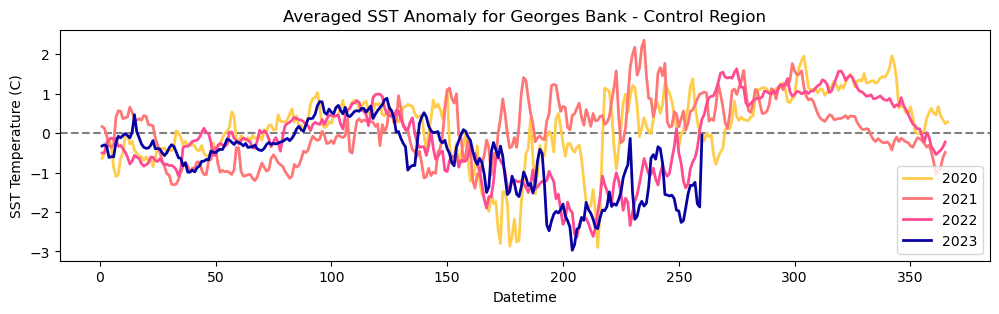

In [11]:
fig,ax=plt.subplots(1, figsize=(12,3))
ax.set_ylabel("SST Temperature (C)")
ax.set_xlabel("Datetime")
ax.set_title("Averaged SST Anomaly for Georges Bank - Control Region")

plt.axhline(0, color='grey', linestyle='--')

ax.plot(sst_result_df_2020.Datetime.dt.dayofyear, sst_result_df_2020.Anomaly, c='#FFCD4B', label='2020', linewidth=2)
ax.plot(sst_result_df_2021.Datetime.dt.dayofyear, sst_result_df_2021.Anomaly, c='#FF7676', label='2021', linewidth=2)
ax.plot(sst_result_df_2022.Datetime.dt.dayofyear, sst_result_df_2022.Anomaly, c='#FF4B91', label='2022', linewidth=2)
ax.plot(sst_result_df_2023.Datetime.dt.dayofyear, sst_result_df_2023.Anomaly, c='#0802A3', label='2023', linewidth=2)

ax.legend()

**Buoy Analysis**

Data from National Data Buoy Center (NDBC)
* https://www.ndbc.noaa.gov
* station 44008 (Georges Bank)
* historical standard meteorological data

In [30]:
buoy_df = pd.DataFrame(columns=['Buoy_ID', 'Lat', 'Lon'])

buoy_df = buoy_df.append({'Buoy_ID': '44008', 'Lat': 40.496, 'Lon': -69.25}, ignore_index=True)
buoy_df = buoy_df.append({'Buoy_ID': '44005', 'Lat': 43.201, 'Lon': -69.127}, ignore_index=True)
#buoy_df = buoy_df.append({'Buoy_ID': '44037', 'Lat': 43.497, 'Lon': -67.876}, ignore_index=True) #Data on different site
buoy_df = buoy_df.append({'Buoy_ID': 'MDRM1', 'Lat': 43.969, 'Lon': -68.128}, ignore_index=True)
buoy_df = buoy_df.append({'Buoy_ID': '44027', 'Lat': 44.283, 'Lon': -67.3}, ignore_index=True)
buoy_df = buoy_df.append({'Buoy_ID': '44098', 'Lat': 42.800, 'Lon': -70.171}, ignore_index=True)

In [31]:
buoy_df

,Buoy_ID,Lat,Lon
0,44008,40.496,-69.250
1,44005,43.201,-69.127
2,MDRM1,43.969,-68.128
3,44027,44.283,-67.300
4,44098,42.800,-70.171


In [32]:
buoy_df_roi = buoy_df[buoy_df['Buoy_ID'] == '44008']
buoy_df_control = buoy_df[buoy_df['Buoy_ID'] != '44008']

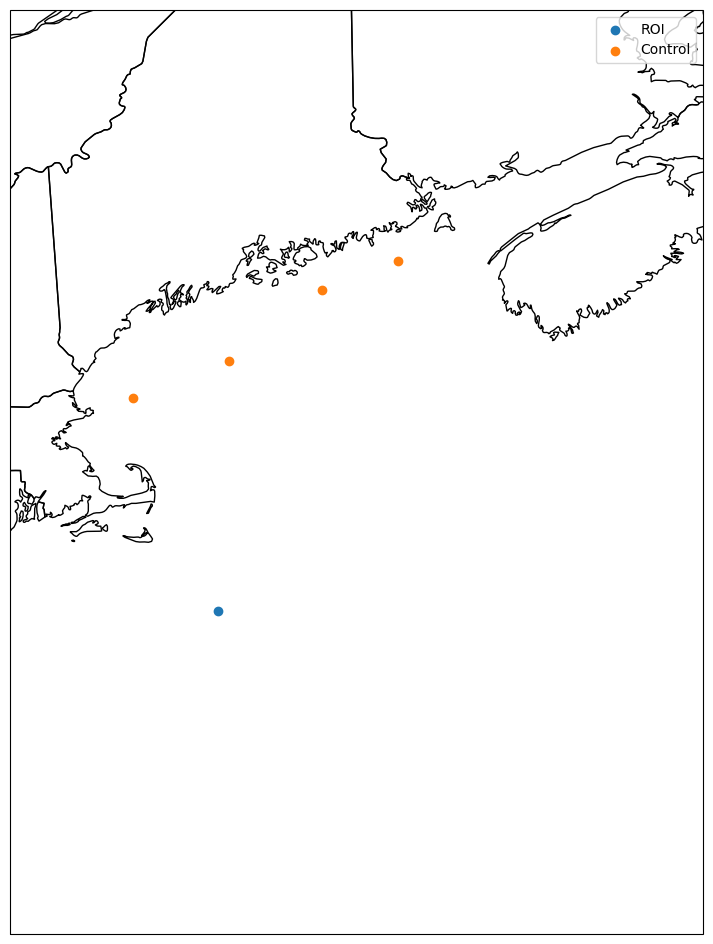

In [33]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})

projection = ccrs.PlateCarree()
ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=projection)

ax.scatter(buoy_df_roi.Lon, buoy_df_roi.Lat, label="ROI")
ax.scatter(buoy_df_control.Lon, buoy_df_control.Lat, label="Control")

ax.add_feature(cfeature.STATES)
ax.legend()